# Wine Quality Project

### Introduction

This project details the steps taken to create a classifier for predicting the quality of a wine given a set of measured data from a wine sample. The model being trained will be a support vector machine and it will be designed to determine if a wine is high quality or not high quality using binary classification. It could be adapted to be a multiclass classifier or regressor to determine a numeric value of the wine quality as well.

The goal of this project is to create a wine predictor that will allow people to input measurements about a new wine and determine if it is a high quality wine. The quality score for each wine used in training was derived as the median score given by 3 different wine experts. Since people may have different opinions about the taste of a wine, the quality may be an objective score. I started out by trying to develop a model that would predict the score between 0-10 but realized this would be a more biased model and people may not be as receptive of its predictions. By generalizing the output to be a simple yes/no answer, the model aims to gain trust of the users by giving an answer they are more likely to believe. This model could be used to determine a good price of a new wine and differentiate it from other similar wines. Using this model could be a cheaper alternative to bringing in wine experts to judge a new type of wine.

### Data

The data was taken from the UCI Machine Learning Repositry Wine Quality Data Set (https://archive.ics.uci.edu/ml/datasets/Wine+Quality). The target attribute is the `quality` field which is a score from 0-10, however we will need to clean this to be a score of 0 or 1 to indicate a high quality wine or not a high quality wine. There are 11 attributes for each samples and we will use feature selection to narrow down the attributes since there may be several correlated features. There are a total of 6497 wine samples in two different data sets with more white wine samples than red. We will keep the two wines separate in our model generation and compare it with a model that is trained on the combined dataset. The reasoning being that there could be different factors that contribute to a high quality red vs a high quality white wine. A detailed description of the dataset can be found in the `winequality.names` file included within this project folder.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

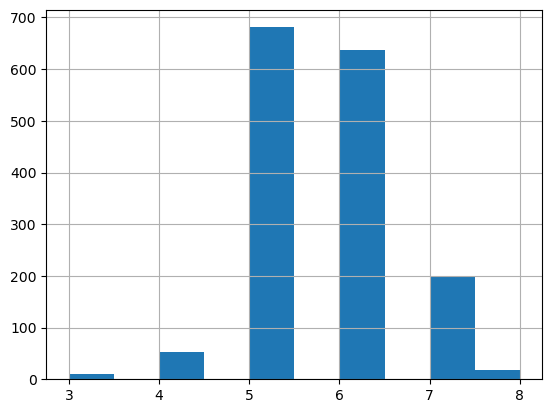

In [14]:
red = pd.read_csv('winequality-red.csv', delimiter=';')
print(red.dtypes)
red.quality.hist()
red.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

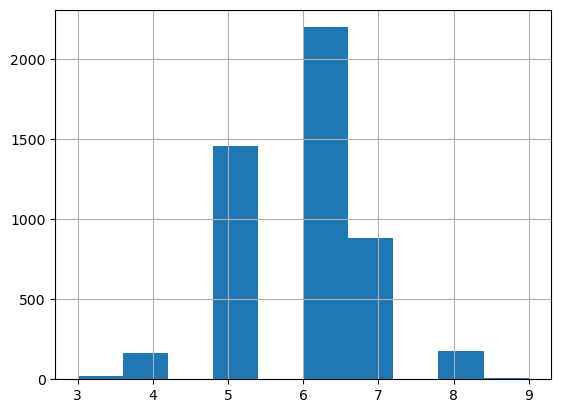

In [16]:
white = pd.read_csv('winequality-white.csv', delimiter=';')
print(white.dtypes)
white.quality.hist()
white.head()

#### Data Cleaning

We notice from the histograms of both of these datasets that there are not many samples of high quality or low quality wines, most quality scores fall within the middle range of 5-7. For our binary classifier, we will say any quality score of 7 or above is considered high quality and any score of 6 or below is not. The quality is encoded into a binary field with 1 for high quality and 0 for not high quality. We will also check if there are any null values in the data that need to be removed. The data will be saved in two distinct sets for red and white as well as one combined set for comparison.

In [28]:
print(f"Null Values: {red.isna().sum().sum() + white.isna().sum().sum()}")

# Save quality score into Y value with 1 if score was 7 or greater, 0 otherwise
red_X = red.drop('quality', axis=1)
white_X = white.drop('quality', axis=1)
combined_X = pd.concat([red_X, white_X])

red_Y = np.where(red.quality >= 7, 1, 0)
white_Y = np.where(white.quality >= 7, 1, 0)
combined_Y = np.concatenate([red_Y, white_Y], axis=0)

Null Values: 0


#### Exploratory Data Analysis

In this section we will inspect the data and see if we can reduce the number of features in our data to help prevent overfitting. First I will generate a correlation matrix and a pairplot for each dataset (white, red, and combined). Using this information I will remove features tham seem to be highly correlated.

We notice from the correlation matrix that the red wine has a high negative correlation between `pH`, `fixed acidity`, and `citric acid`. This is unsurprising since all of these are related to the acidic levels of the wine. There is also a strong positive correlation between `fixed acidity` and `density` as well as `free sulfur dioxide` and `total sulfur dioxide`. Therefore we will drop the `fixed acidity`, `citric acid`, and `free sulfur dioxide` fields.

For the white wine we see from the correlation matrix that there is a correlation between `alcohol` and `density` as well as `density` and `pH`. Similar to the red wines there is also correlation between `free sulfur dioxide` and `total sulfur dioxide`. Thus we will drop `density` and `free sulfur dioxide`. This is a surprising result as I would have expected a similar set of correlated features between the two types of wines.

<Axes: title={'center': 'Combined'}>

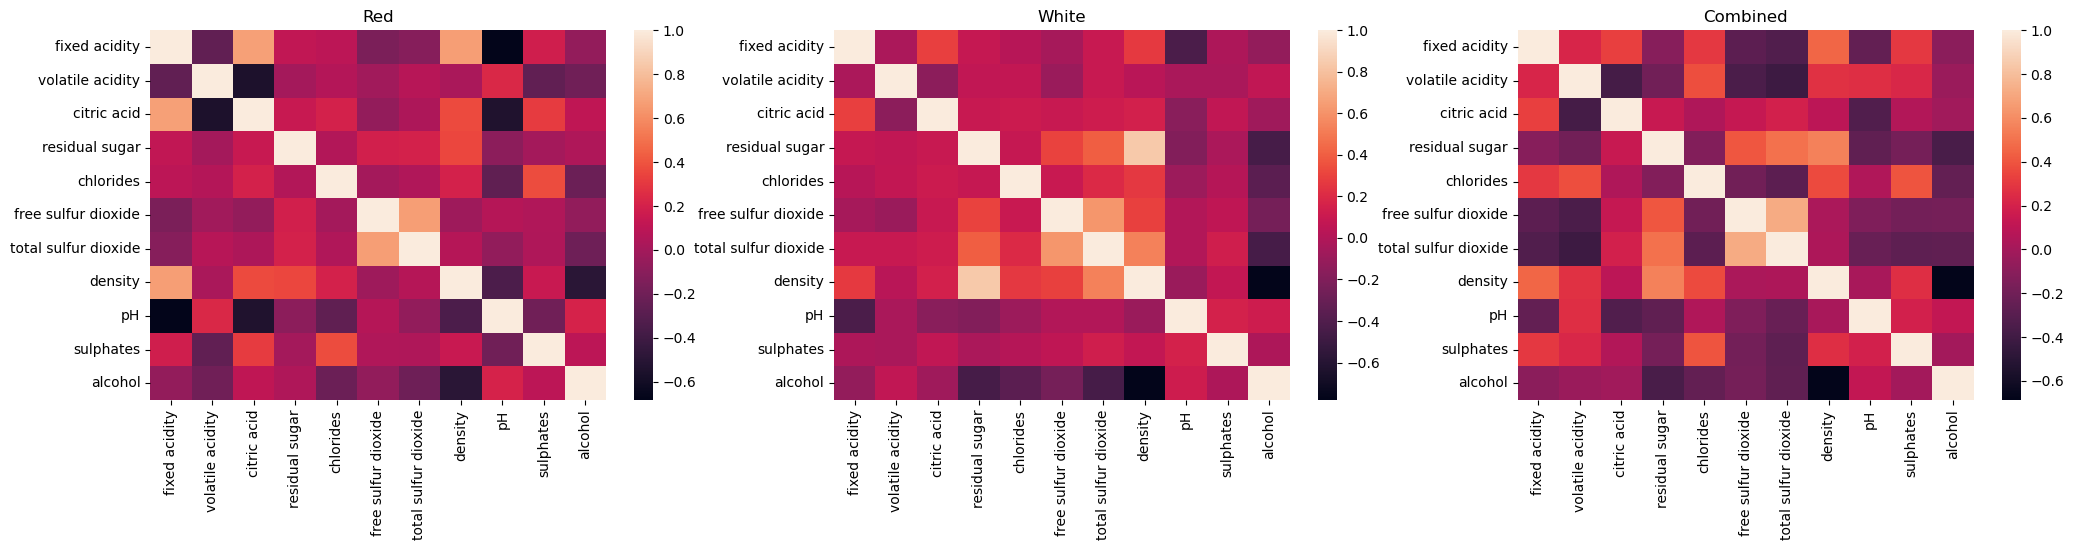

In [36]:
# Plot correlation matrices
fig, ax = plt.subplots(ncols=3)
fig.set_figwidth(25)
ax[0].title.set_text("Red")
sns.heatmap(red_X.corr(), ax=ax[0])
ax[1].title.set_text("White")
sns.heatmap(white_X.corr(), ax=ax[1])
ax[2].title.set_text("Combined")
sns.heatmap(combined_X.corr(), ax=ax[2])

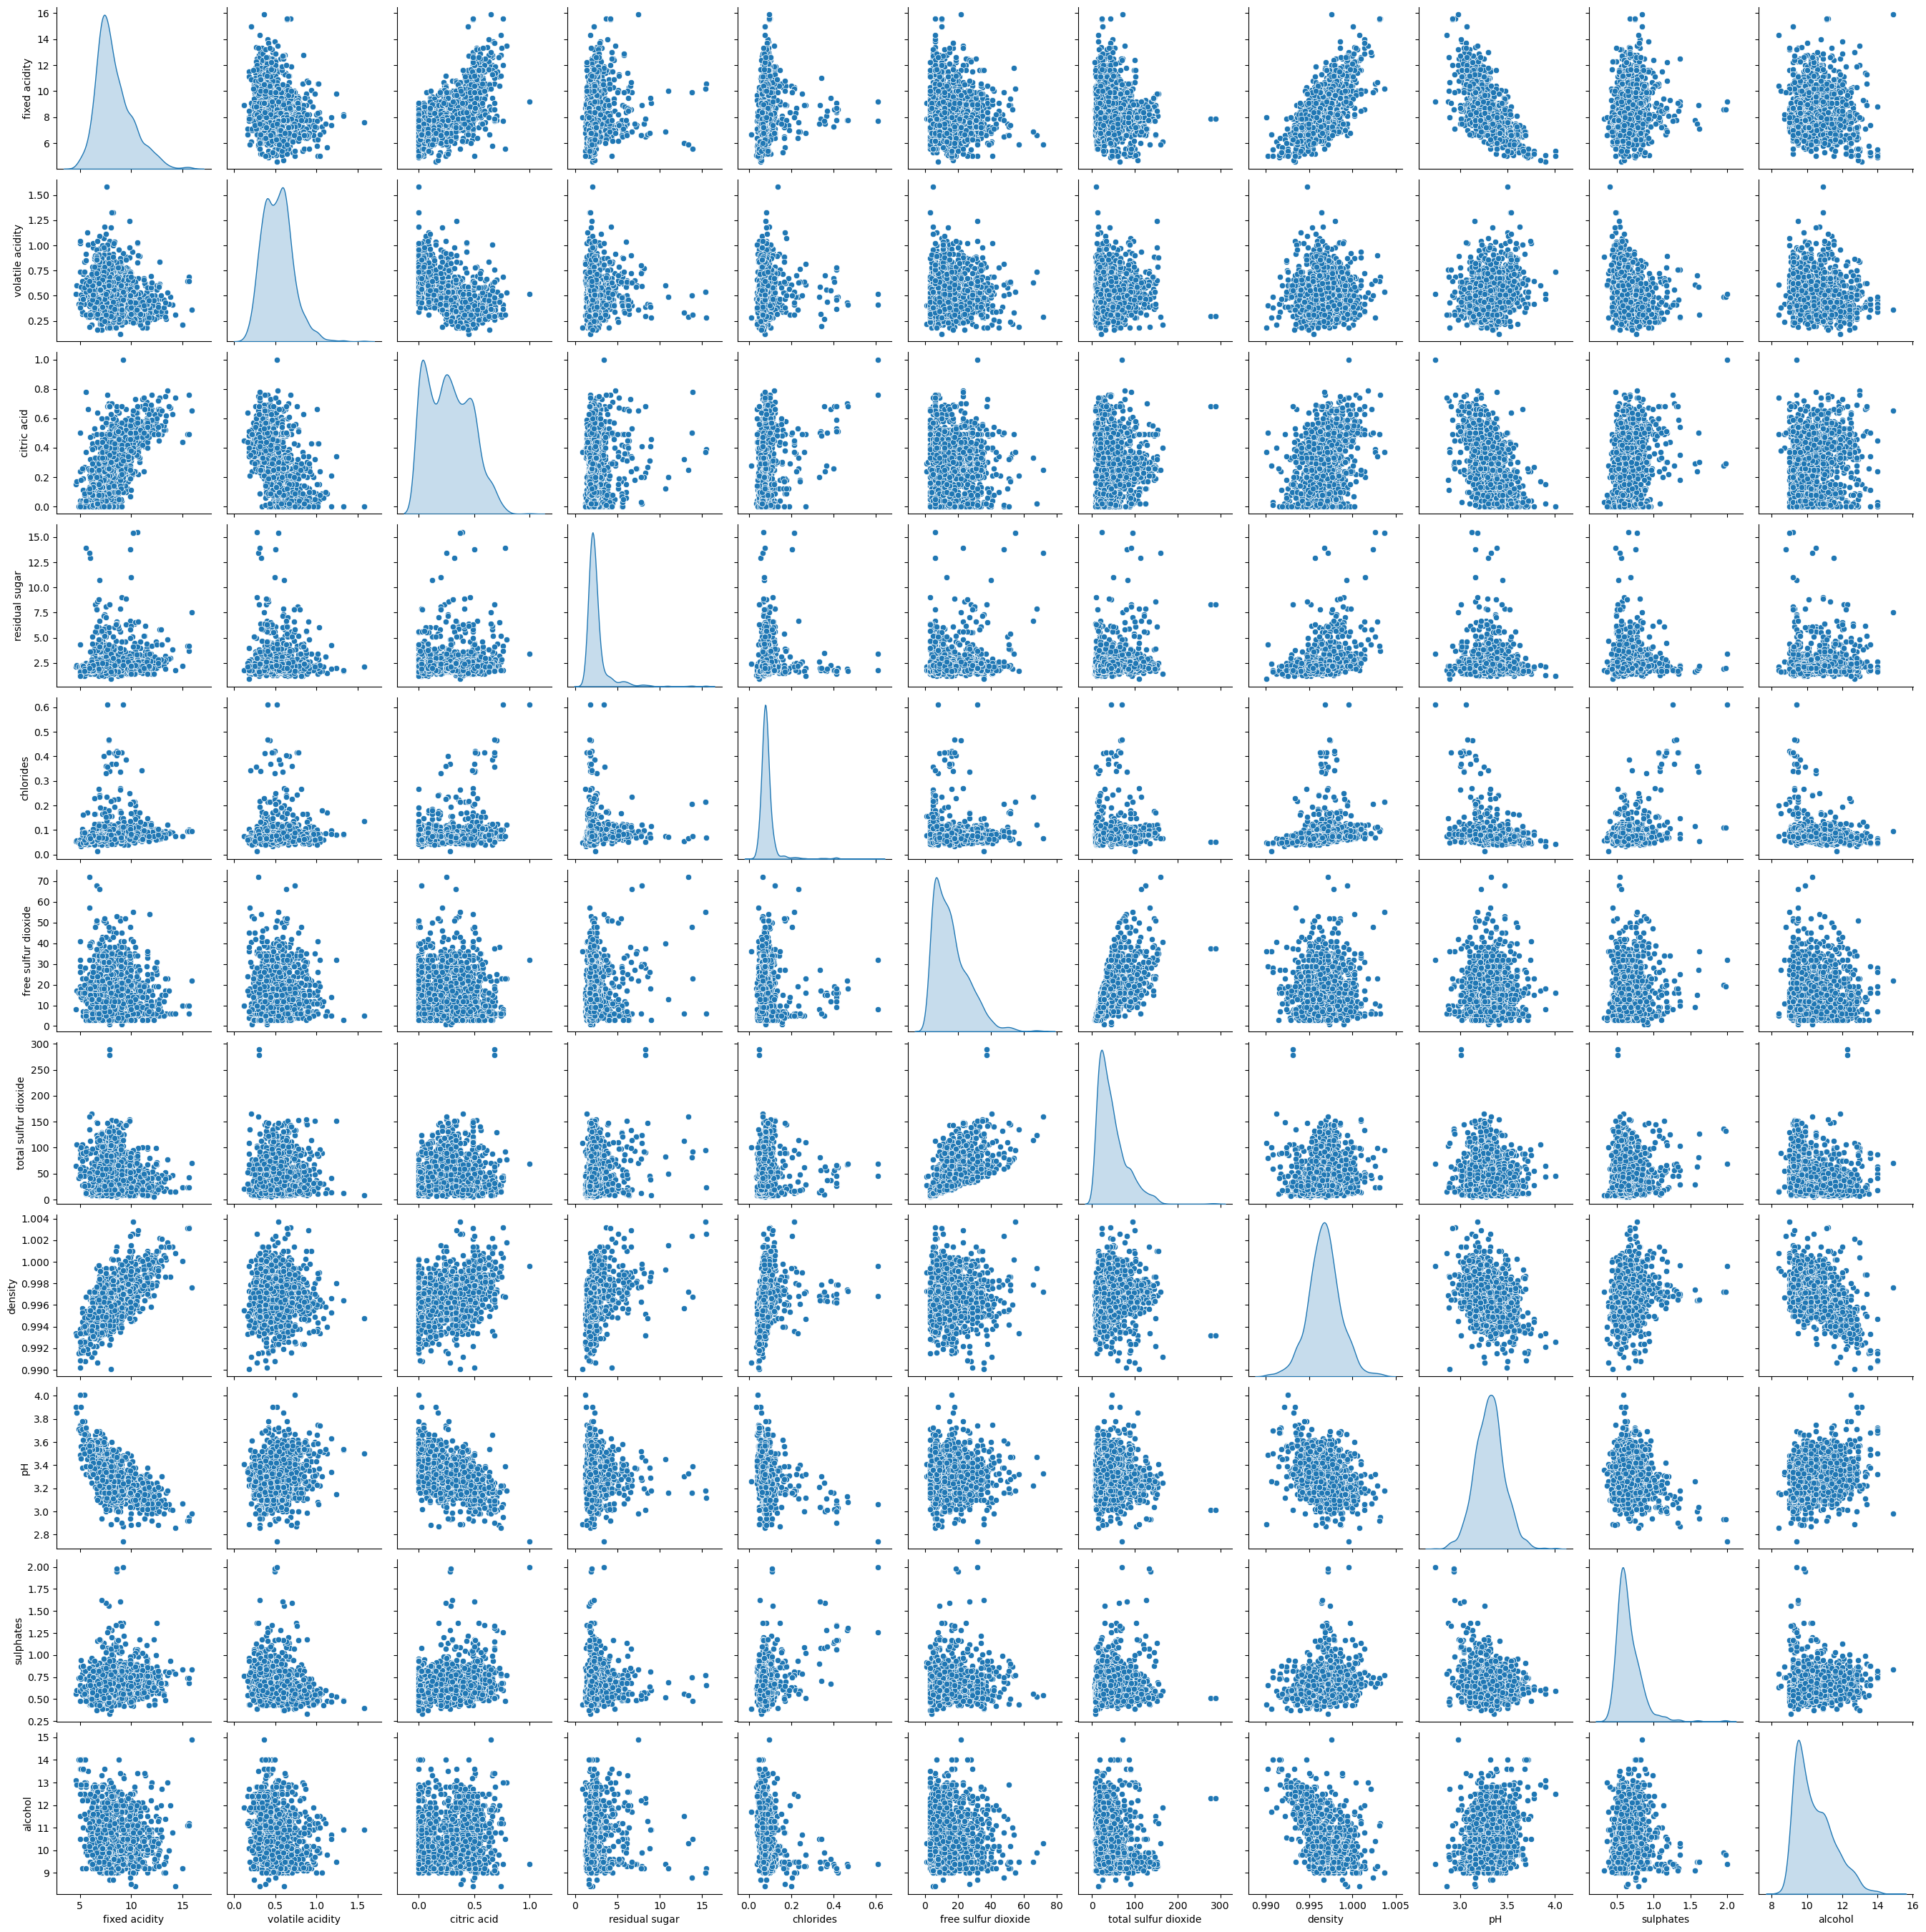

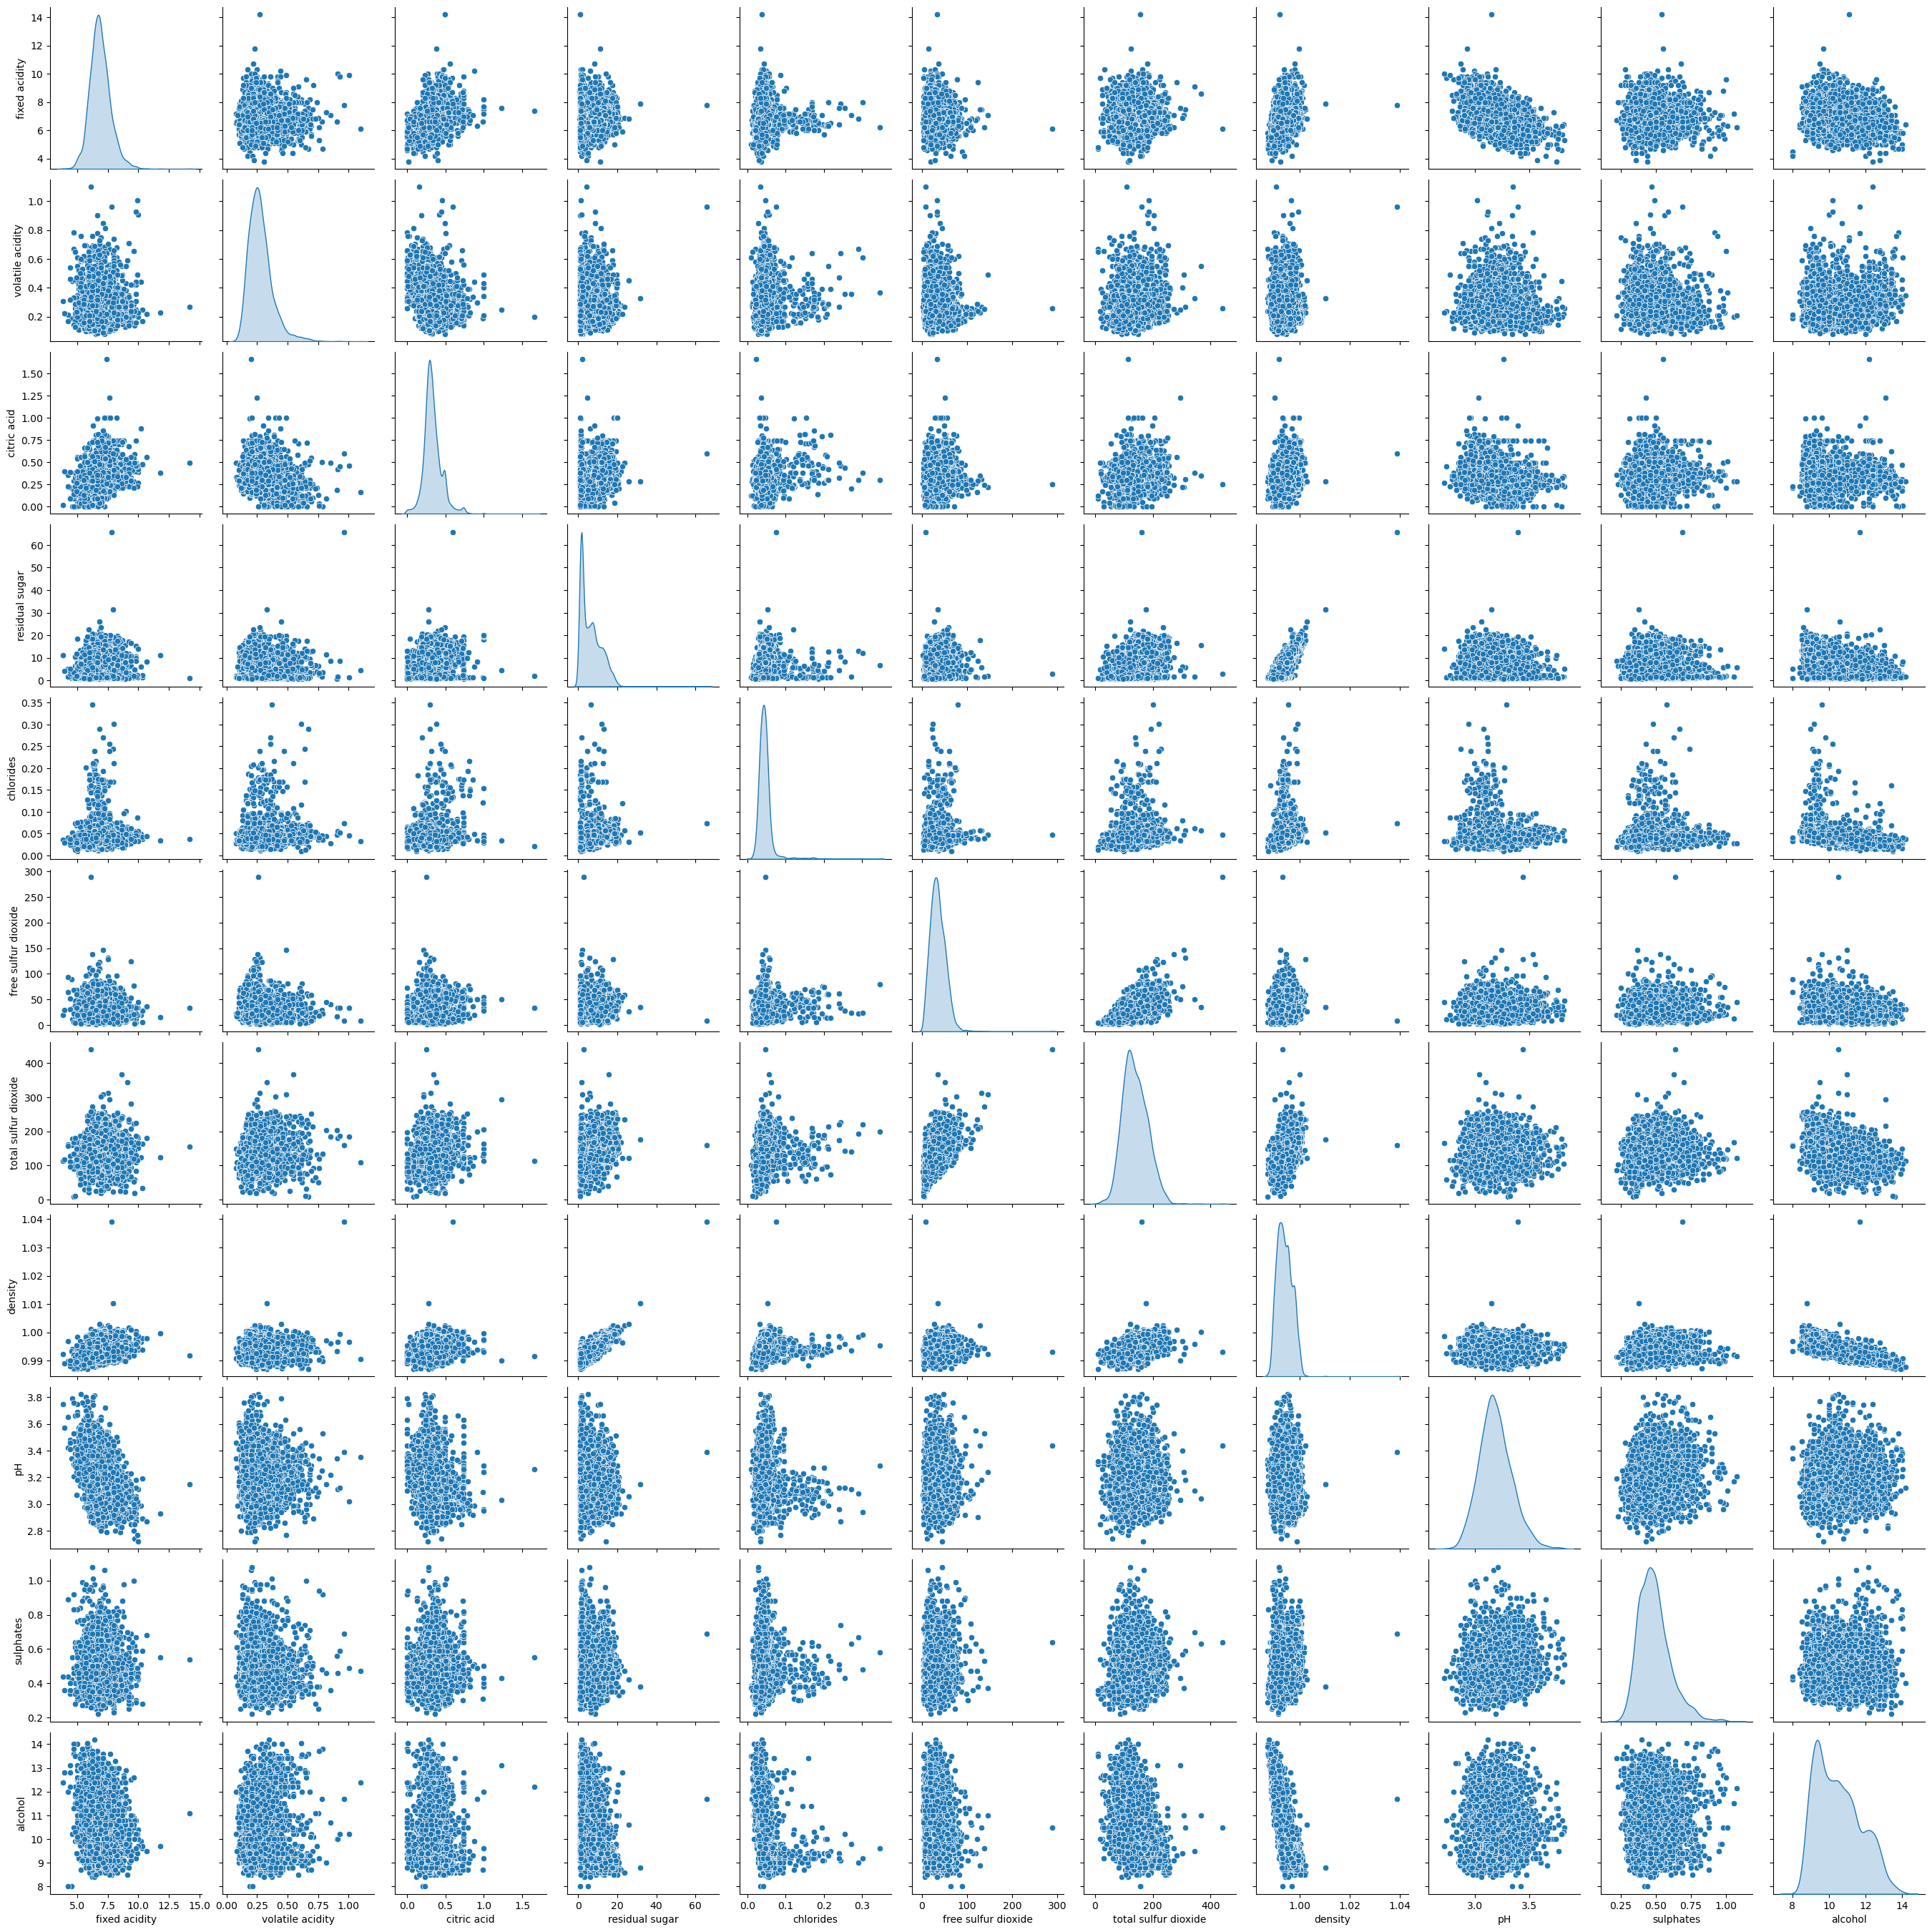

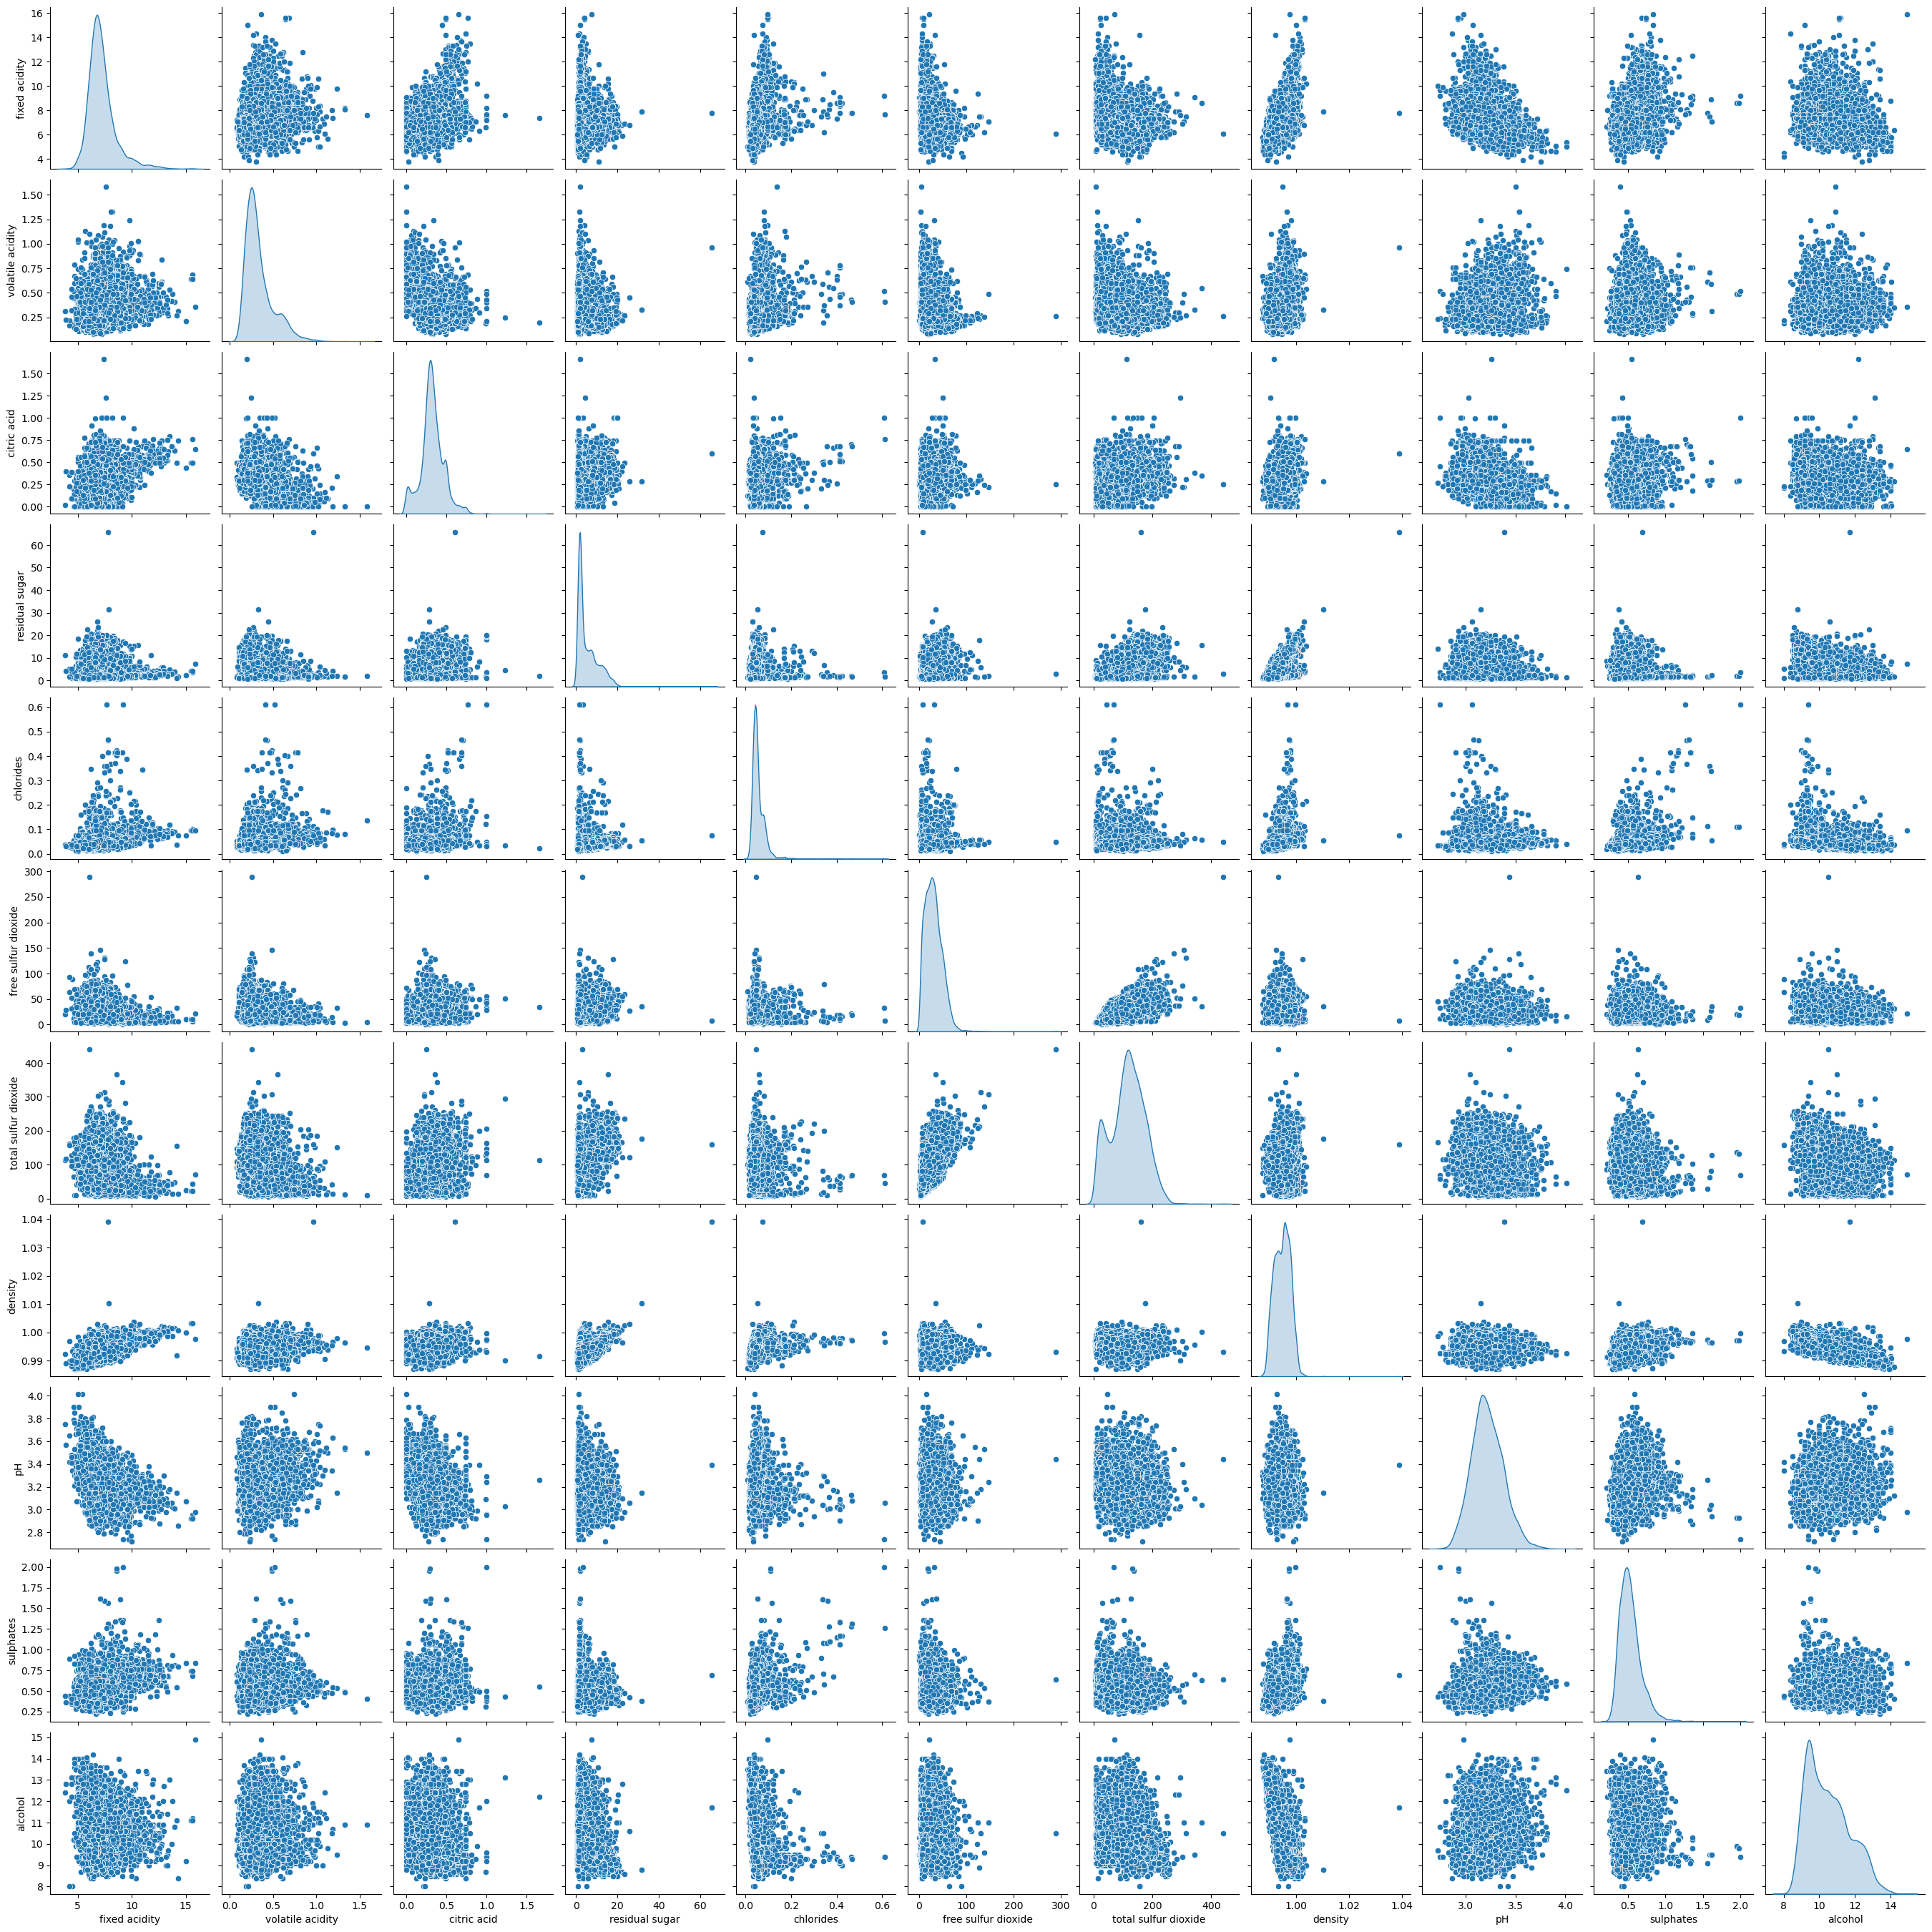

In [39]:
# Plot pairplots
sns.pairplot(red_X, diag_kind='kde')
sns.pairplot(white_X, diag_kind='kde')
sns.pairplot(combined_X, diag_kind='kde')

As shown in the plots, we see that red wine has a high negative correlation between `pH`, `fixed acidity`, and `citric acid`. This is not a surprise since all of these are related to the acidity. There is also a strong positive correlation between `fixed acidity` and `density` as well as `free sulfur dioxide` and `total sulfur dioxide`. Therefore we will drop the `fixed acidity`, `citric acid`, and `free sulfur dioxide` fields to remove the correlated features.

For the white wine dataset we see there is a correlation between `alcohol` and `density` as well as `density` and `pH`. Similar to the red wines there is also correlation between `free sulfur dioxide` and `total sulfur dioxide`, thus we will drop `density` and `free sulfur dioxide`. This is a somewhat surprising result as I would have expected a similar set of correlated features between the two types of wines.

Finally for the combined set there is less correlation but we will remove the `density` category as well.

In [ ]:
red_X.drop(['fixed acidity', 'citric acid', 'free sulfur dioxide'], axis=1, inplace=True)
white_X.drop(['density', 'free sulfur dioxide'], axis=1, inplace=True)
combined_X.drop(['density'], axis=1, inplace=True)

### Models

The model we use is a support vector machine for binary classification. I chose this model because it can be used easily for classification tasks and can support a large number of features. I will use GridSearch to do hyperparameter tuning and generate the most accurate model using cross validation. There should be no effects of interaction between the features since we removed correlated features in the previous step. Reducing the number of features should also help reduce overfitting since too many features indicating the same result will cause too much weight to be given to the given cause. I also addressed data imbalance by creating two separate models on the data sets.

In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

red_params = {
    "C": np.logspace(-5, 5, num=10, base=2),
    "gamma": np.logspace(-5, 5, num=10, base=2),
}
red_grid = GridSearchCV(SVC(), param_grid=red_params, cv=3)
red_grid.fit(red_X, red_Y)

print(red_grid.best_params_)
print(red_grid.best_score_)

#linear
# {'C': 0.03125, 'gamma': 0.03125}
# 0.864290181363352

{'C': 1.4697344922755986, 'gamma': 0.3149802624737183}
0.8667917448405253


In [43]:
white_params = {
    "C": np.logspace(-5, 5, num=10, base=2),
    "gamma": np.logspace(-5, 5, num=10, base=2),
}
white_grid = GridSearchCV(SVC(), param_grid=white_params, cv=3)
white_grid.fit(white_X, white_Y)

print(white_grid.best_params_)
print(white_grid.best_score_)

{'C': 1.4697344922755986, 'gamma': 1.4697344922755986}
0.7841974052327606


In [44]:
combined_params = {
    "C": np.logspace(-5, 5, num=10, base=2),
    "gamma": np.logspace(-5, 5, num=10, base=2),
}
combined_grid = GridSearchCV(SVC(), param_grid=combined_params, cv=3)
combined_grid.fit(combined_X, combined_Y)

print(combined_grid.best_params_)
print(combined_grid.best_score_)

{'C': 1.4697344922755986, 'gamma': 3.1748021039363996}
0.8059105768554118


#### Results and Analysis

I ran through several iterations of GridSearch to implement hyperparameter tuning and cross validation to help select the best model. Unfortunately each training run took a long time to complete so I was only able to iterate over a few different combinations. I found that linear models performed better than polynomial while rbf performed better than both linear and sigmoid. The final models used rbf kernels and acheived an accuracy over 80% which could most lilkely be improved with further model analysis. The following charts show the validation accuracy for each model.

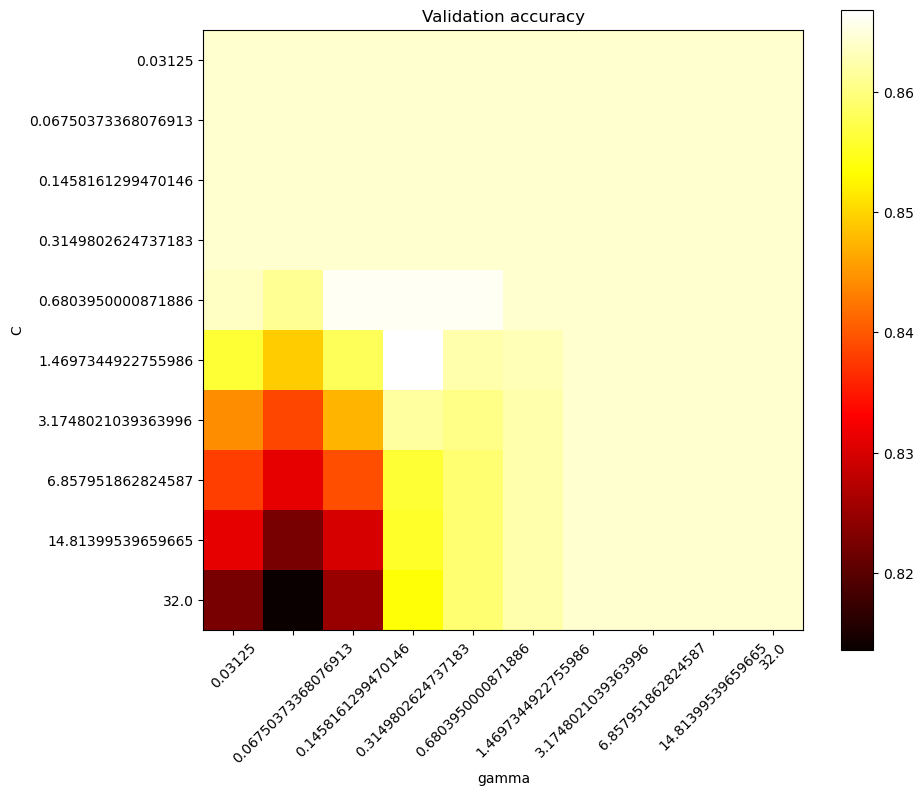

In [45]:
red_scores = [x for x in red_grid.cv_results_["mean_test_score"]]
red_scores = np.array(red_scores).reshape(len(red_grid.param_grid["C"]), len(red_grid.param_grid["gamma"]))

plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(red_scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(red_grid.param_grid["gamma"])), red_grid.param_grid["gamma"], rotation=45)
plt.yticks(np.arange(len(red_grid.param_grid["C"])), red_grid.param_grid["C"])
plt.title('Validation accuracy')
plt.show()

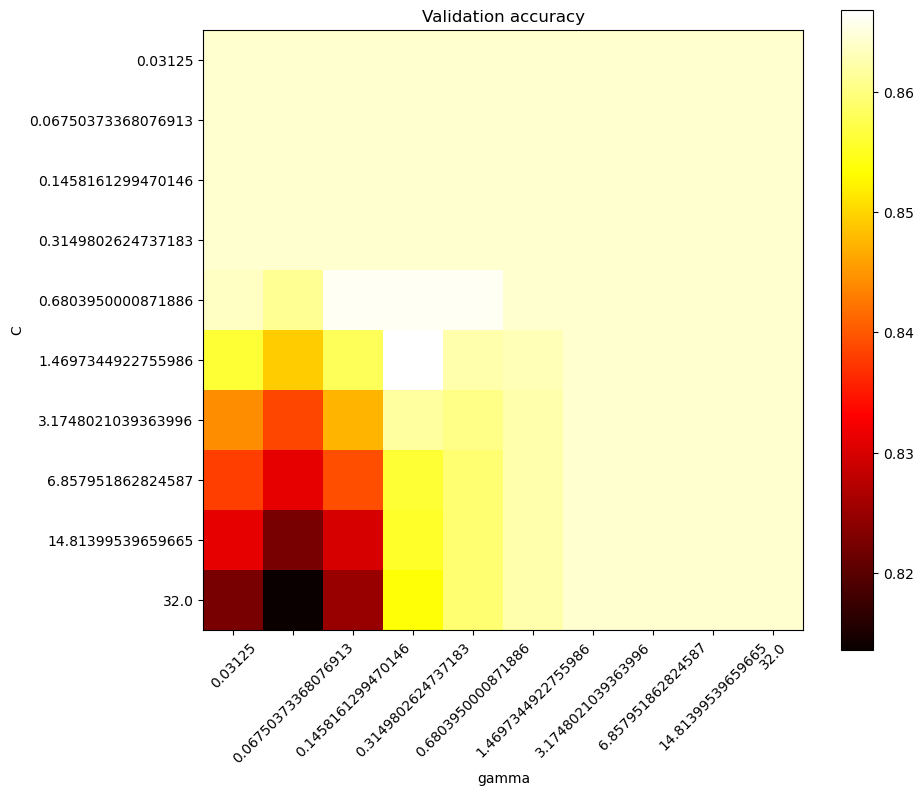

In [46]:
white_scores = [x for x in white_grid.cv_results_["mean_test_score"]]
white_scores = np.array(white_scores).reshape(len(white_grid.param_grid["C"]), len(white_grid.param_grid["gamma"]))

plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(red_scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(white_grid.param_grid["gamma"])), white_grid.param_grid["gamma"], rotation=45)
plt.yticks(np.arange(len(white_grid.param_grid["C"])), white_grid.param_grid["C"])
plt.title('Validation accuracy')
plt.show()

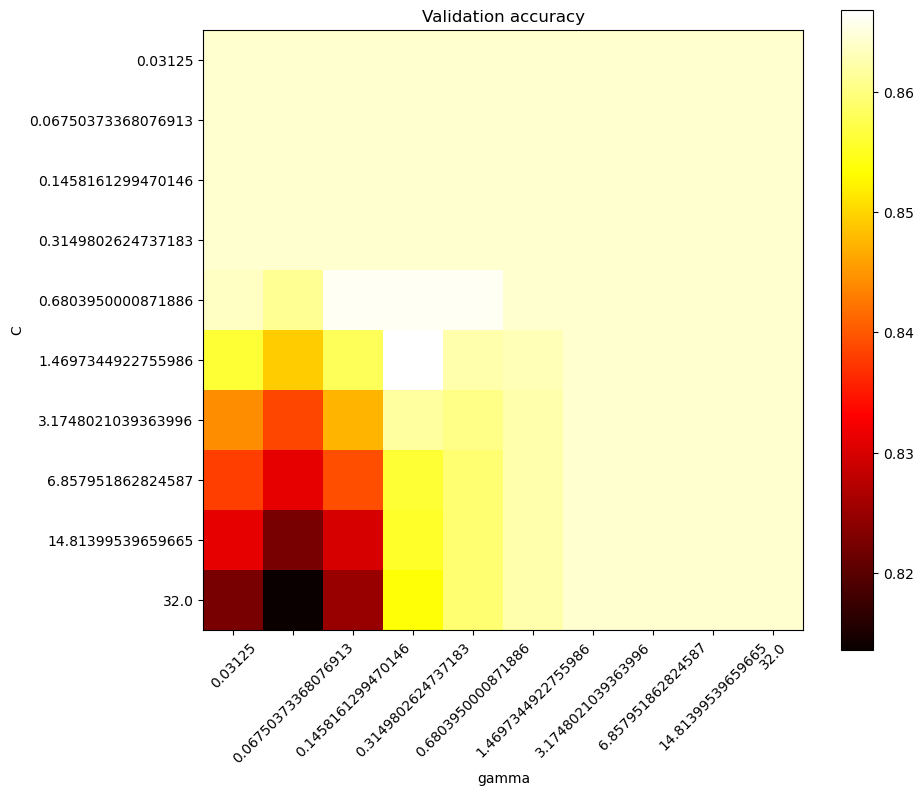

In [47]:
combined_scores = [x for x in combined_grid.cv_results_["mean_test_score"]]
combined_scores = np.array(combined_scores).reshape(len(combined_grid.param_grid["C"]), len(combined_grid.param_grid["gamma"]))

plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(red_scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(combined_grid.param_grid["gamma"])), combined_grid.param_grid["gamma"], rotation=45)
plt.yticks(np.arange(len(combined_grid.param_grid["C"])), combined_grid.param_grid["C"])
plt.title('Validation accuracy')
plt.show()

#### Conclusion

This models created in this project were able to generate a classification for a high quality wine with fairly strong results. I learned that it takes a long time for model optimization since it requires a lot of trial and error. Automating this with something like GridSearch is a great way to try lots of different approaches and see which one works the best. A good starting point to developing these models was researching the data and building domain knowledge to help with some of the data exploration tasks. The more I knew about the data the better decisions I could make in interpreting the results. The models perhaps could have been improved if I tried more hyperparameters. Another approach would have been combining the results of the models by choosing the most common classification out of several different model outputs.

If we wanted to create a classifier that would put out an actual quality score between 0-10 then I could have experimented with forests or restructured the data to support multi class classification with SVMs. To do this I would take a one vs rest approach by generating 11 different binary classification models for each of the valid scores and the model that was most confident about its classification would have assigned the score to the wine sample. Another thing I learned is that there are many different ways to create models to do what we want. I could have used a linear regression model to generate a number between 0-10 and the classification would have been assigned based on which number if was closest to. In order to do this however, I would have needed more data points at the high and low end of the score range. If you recall, the majority of scores fell between 4-7 and for a model to be the most accurate, it needs an even sample of all the valid scores. Otherwise it will overfit to the few values that have the most samples.

I hope this project was informative and you can find a use for a wine quality classifier. The project can be found on github at (https://github.com/WyattHough/msds/tree/main/supervised_learning/wine_quality).